<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/blob/main/4.model_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from google.colab import drive
import pickle
import pandas as pd

In [ ]:
# PEP 8
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

In [ ]:
# %%pycodestyle
from dataclasses import dataclass
from dataclasses import field
import os
import pickle


@dataclass
class PathManager:
    competition_path: str
    preprocessing_trial: int
    models_trial: int

    def __post_init__(self):
        self.data_root_path = os.path.join(self.competition_path, 'Data')
        self.models_root_path = os.path.join(self.competition_path, 'Models')

        self.data_trial_path = os.path.join(
            self.data_root_path,
            f'preproc_trial_{self.preprocessing_trial}'
        )
        self.models_trial_path = os.path.join(
            self.models_root_path,
            f'trial_{self.models_trial}'
        )

    @property
    def train_path(self):
        return os.path.join(self.data_root_path, 'train.csv')

    @property
    def test_path(self):
        return os.path.join(self.data_root_path, 'test.csv')

    def _create_path(self, path):
        if not os.path.isdir(path):
            os.mkdir(path)
        else:
            print(f'{path} already exists')

    def save_to_csv(self, array_, path_, file_name_):
        df = pd.DataFrame(array_)
        df.to_csv(os.path.join(path_, file_name_))

    def setup_paths(self):
        # precondition
        assert os.path.isdir(self.data_root_path), print(self.data_root_path)
        assert os.path.isdir(self.models_root_path), \
            print(self.models_root_path)

        self._create_path(self.data_trial_path)
        self._create_path(self.models_trial_path)

    def save_models(self, sklearn_models_dict_):
        '''
        For each model in the dictionary, create a folder.
        Save pickle file there. If model (or folder) already exists -
        overrides all files
        '''
        for model_name, sklearn_model in sklearn_models_dict_.items():
            folder_path = os.path.join(
                self.models_trial_path, model_name
            )
            self._create_path(folder_path)
            model_filename = model_name + '.sav'
            pickle.dump(
                sklearn_model,
                open(
                    os.path.join(folder_path, model_filename),
                    'w+b'
                ),
            )

    def load_models(self, models_subfolders_=[]):
        '''
        1. Goes to self.models_trial_path
        2. If models_names=[] - downloads all
           models from their subfolders.
        3. models_names must contain names of subfolders on
           google drive!
        '''

        # precondition
        assert os.path.isdir(self.models_trial_path), \
            print(self.models_trial_path)

        available_models_subfolders = os.listdir(self.models_trial_path)
        if models_subfolders_:
            models_to_download = models_subfolders_
        else:
            # Download everything
            models_to_download = available_models_subfolders

        res = {}
        for model_subfolder in models_to_download:
            # file name coincides with folder name
            file_name = f'{model_subfolder}.sav'
            full_path = os.path.join(
                self.models_trial_path,
                model_subfolder,
                file_name
            )

            loaded_model = pickle.load(
                open(full_path, 'rb')
            )
            res[model_subfolder] = loaded_model
        return res


pep8(_ih)

# Setup paths

In [ ]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'

COMPETITION_PATH = gdrive_path + 'ML/Competitions/5.RestaurantRevenue/'
PREPROC_TRIAL = 1
MODELS_TRIAL = 1

pep8(_ih)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).



In [ ]:
path_manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)

pep8(_ih)

# Download models

In [ ]:
models = path_manager.load_models(
    [
        'random_forest',
        'elastic_net_final'
    ]
)

In [ ]:
models

{'random_forest': RandomForestRegressor(n_estimators=500),
 'elastic_net_final': ElasticNet(alpha=0.5, l1_ratio=0.2)}

# Download data

In [ ]:
df_test = pd.read_csv(
    os.path.join(
        path_manager.data_trial_path,
        'test_processed.csv'
    ),
    index_col=[0]
)

# subsample from train.csv for testing
df_test_sample = pd.read_csv(
    os.path.join(
        path_manager.data_trial_path,
        'test_sample_processed.csv'
    ),
    index_col=[0]
)

df_trainval = pd.read_csv(
    os.path.join(
        path_manager.data_trial_path,
        'trainval_sample_processed.csv'
    ),
    index_col=[0]
)

X_train_val = df_trainval.values[:, :-1]
Y_train_val = df_trainval.values[:, -1]

X_test_sample = df_test_sample.values[:, :-1]
Y_test_sample = df_test_sample.values[:, -1]

# Cross validation performance for final models

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

def print_model_cv_scores(sklearn_models_dict_, X_, Y_, cv_, scoring_):
    res = {}
    for name, model in sklearn_models_dict_.items():
        scores = cross_val_score(
            model,
            X_,
            Y_,
            cv=cv_,
            scoring=scoring_
        )
        res[name] = scores
    
    # Sort the dict
    sorted_res = {
        k:v for \
        k, v in sorted(res.items(), key = lambda item: np.mean(item[1]))
    }
    for model_name, scores in sorted_res.items():
        print(f'Model: {model_name}, mean: {np.mean(scores)}, std: {np.std(scores)}')

    return sorted_res

In [ ]:
_ = print_model_cv_scores(
    models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=7,
    scoring_='neg_mean_squared_error'
)

Model: elastic_net_final, mean: -0.20073170318480518, std: 0.08848660198096124
Model: random_forest, mean: -0.1853705381862795, std: 0.06706198983224765


# Cross validation metrics (check possible overfit)

In [ ]:
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt


def plot_cv_results(
    sklearn_models_dict_,
    X_,
    Y_,
    cv_,
    scoring_,
    to_put_minus_=False
):

    for model_name, model in sklearn_models_dict_.items():
        cv_res = cross_validate(
            model,
            X_,
            Y_,
            cv=cv_,
            scoring=scoring_,
            return_train_score=True
        )
        _, ax = plt.subplots()
        x = np.arange(len(cv_res['test_score']))
        width = 0.5
        if to_put_minus_:
            train_score = -cv_res['train_score']
            test_score = -cv_res['test_score']
        else:
            train_score = cv_res['train_score']
            test_score = cv_res['test_score']

        ax.bar(x - width / 2, test_score, width, label='validation')
        ax.bar(x + width / 2, train_score, width, label='train')

        ax.set_title(f'Results for {model_name}')
        ax.set_xlabel(f'CV fold number')
        ax.set_ylabel(f'Metrics: {scoring_}')

        ax.legend()
        ax.grid()


pep8(_ih)

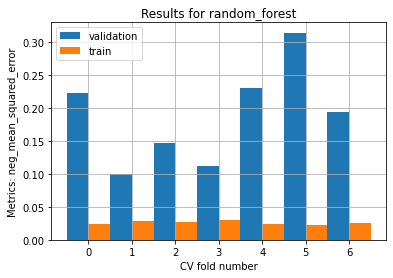

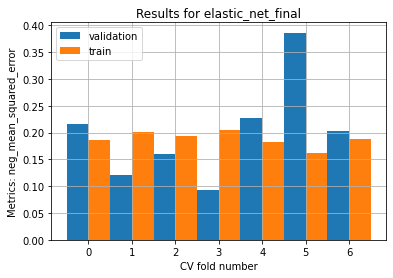

In [ ]:
_ = plot_cv_results(
    models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=7,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

# Report test sample performance

In [ ]:
final_model = models['elastic_net_final']

final_model.fit(
    X_train_val,
    Y_train_val
)

ElasticNet(alpha=0.5, l1_ratio=0.2)

In [ ]:
from sklearn.metrics import mean_squared_error


test_sample_predictions = final_model.predict(X_test_sample)
test_result = mean_squared_error(
    test_sample_predictions,
    Y_test_sample
)
print(test_result)

pep8(_ih)

0.21245325524449132



# Retraining on all available data

In [ ]:
final_arr = np.vstack([X_train_val, X_test_sample])
final_target = np.hstack([Y_train_val, Y_test_sample])
final_arr.shape,  final_target.shape

((137, 43), (137,))

In [ ]:
final_model.fit(
    final_arr,
    final_target
)

ElasticNet(alpha=0.5, l1_ratio=0.2)

# Submission and saving final model

In [ ]:
df_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-1.032819,-0.285964,-0.26814,-0.383325,-0.807152,-0.633614,-0.182156,-0.619713,-0.217343,-0.244523,...,-0.606797,-0.556056,-0.652386,2011.0,0.0,0.0,1.0,0.0,0.341412,0.693147
1,-0.334236,-0.285964,-0.26814,-0.383325,0.014161,-0.633614,-0.182156,-1.176974,-0.790338,-0.811816,...,-0.606797,-0.556056,-0.652386,2011.0,0.0,0.0,0.0,1.0,2.161000,0.693147


In [ ]:
# Remove target (that was artificially created during data processing pipeline)
submission_data = df_test.values[:, :-1]
submission_data.shape

(100000, 43)

In [ ]:
final_predictions = np.exp(
    final_model.predict(submission_data)
)

In [ ]:
df_submission = pd.DataFrame(final_predictions, columns=['Prediction'])
df_submission.index.rename('Id', inplace=True)
df_submission.head()

,Prediction
Id,
0,3.307691e+06
1,3.410696e+06
2,3.433673e+06
3,3.229931e+06
4,3.160507e+06


In [ ]:
final_model_name = 'ElasticSubmission'

submission_path = os.path.join(
    path_manager.models_trial_path,
    final_model_name,
    'submission.csv'
)

path_manager.save_models(
    {
        'ElasticSubmission': final_model
    }
)
df_submission.to_csv(submission_path)

/content/gdrive/MyDrive/ML/Competitions/5.RestaurantRevenue/Models/trial_1/ElasticSubmission already exists
